🌿Preprocessing

In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle

# load test data
mnist_path = "/home/ajay2425/rclass/mnist_dataset/mnist.npz" #main
with np.load(mnist_path) as data:
    x_test = data["x_test"]
    y_test = data["y_test"]
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

# 1. Flatten
x_test_flat = x_test.reshape(x_test.shape[0], -1)
print(f"1. x_test_flat shape: {x_test_flat.shape}, y_test shape: {y_test.shape}")

# 2. Subsets
subset_size = 10000
x_test_subset = x_test_flat[:subset_size]
y_test_subset = y_test[:subset_size]
print(f"2. x_test_subset shape: {x_test_subset.shape}")

# 3. PCA
pca_model_path = "/home/ajay2425/rclass/models/models_grb/trained_pca.pkl" #main
# pca_model_path = "/home/ajay2425/rclass/models/add/trained_pca.pkl" # temp.
with open(pca_model_path, "rb") as file:
    pca = pickle.load(file)
print("(trained pca model loaded)")
# apply pca to the test data
x_test_pca = pca.transform(x_test_subset)  # Use the same pca model from training
print(f"3. x_test_pca shape: {x_test_pca.shape}")
variance = np.sum(pca.explained_variance_ratio_)
print(f"variance = {variance}")

x_test_norm = x_test_pca

# # 4. Normalize
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 1))
# x_test_norm = scaler.fit_transform(x_test_pca)
# print(f"4. x_test_norm shape: {x_test_norm.shape}")

# # 4. Binarize
# threshold_value = 0
# x_test_norm = (x_test_pca > threshold_value).astype(int)
# print(f"4. x_test_norm shape: {x_test_norm.shape}")

x_test shape: (10000, 28, 28), y_test shape: (10000,)
1. x_test_flat shape: (10000, 784), y_test shape: (10000,)
2. x_test_subset shape: (10000, 784)
(trained pca model loaded)
3. x_test_pca shape: (10000, 20)
variance = 0.6489967153651949


🌿Generate multi-indices

In [2]:
import time
# Start timer
start_time = time.time()

def r_multi_indices(n, d):
    if n == 1:
        yield (d,)
    else:
        for k in range(d + 1):
            for c in r_multi_indices(n - 1, k):
                yield (d - k, *c)

def generate_multi_indices(n, d):
    from itertools import chain
    return list(chain(*[list(r_multi_indices(n, _)) for _ in range(d + 1)]))

import pickle
import os
models_dir = "/home/ajay2425/rclass/models/models_grb/"
# Load the model for the current digit
model_path = f"{models_dir}/classifier_0.pkl"
with open(model_path, "rb") as file:
    model = pickle.load(file)
# Extract model parameters
n_components = model["n_components"]
d = model["degree"]
c = generate_multi_indices(n_components, d)
print(f"no_of_coeff =", len(c))

no_of_coeff = 231


🌿Generate polynomials

In [3]:
import numpy as np
def construct_G_H_matrices(x_test_norm, n, d):
    num_data_points = x_test_norm.shape[0]
    multi_indices = generate_multi_indices(n, d)
    num_coefficients = len(multi_indices)

    # Initialize G and H matrices
    G = []
    H = []

    # Construct G and H using multi-indices
    for i in range(num_data_points):
        G_row = []
        H_row = []
        for idx in multi_indices:
            term = np.prod([x_test_norm[i, k] ** idx[k] for k in range(n)])
            G_row.append(term)
            H_row.append(term)
        G.append(G_row)
        H.append(H_row)

    # Convert G and H to NumPy arrays
    G = np.array(G)
    H = np.array(H)

    # Normalize G and H row-wise for numerical stability
    G = G / np.linalg.norm(G, axis=1, keepdims=True)
    H = H / np.linalg.norm(H, axis=1, keepdims=True)

    return G, H, multi_indices

🌿Load saved models

In [4]:
import pickle
import os

models_dir = "/home/ajay2425/rclass/models/models_grb/"

# Load all classifiers into memory
classifiers = {}
for digit in range(10):
    model_path = f"{models_dir}/classifier_{digit}.pkl"
    if os.path.exists(model_path):
        with open(model_path, "rb") as file:
            classifiers[digit] = pickle.load(file)
    else:
        print(f"Model for digit {digit} not found!")

🌿Test

Overall Testing Accuracy: 85.37%
Total Testing Time: 163.05 seconds

Overall Recall: 85.37%
Overall F1-Score: 85.30%


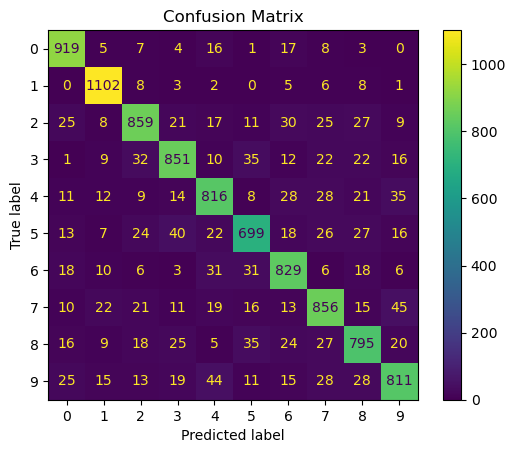

In [5]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Initialize an array to store predictions
predictions = []

# Loop through each test sample
for i, test_samples in enumerate(x_test_norm):
    confidence_scores = []

    # Pass the test sample through each classifier
    for digit in range(10):

        # Load the model for the current digit
        model_path = f"{models_dir}/classifier_{digit}.pkl"
        with open(model_path, "rb") as file:
            model = pickle.load(file)
        # Extract model parameters
        alpha = model["alpha"]
        beta = model["beta"]
        theta = model["theta"]
        multi_indices = model["multi_indices"]

        test_sample_array = np.array([test_samples])

        # Compute the rational function value for the current classifier
        G, H, _ = construct_G_H_matrices(test_sample_array, model["n_components"],  model["degree"])
        numerator = np.dot(G[0], alpha)
        denominator = np.dot(H[0], beta)

        # if np.abs(denominator) < 1e-8:
        if np.abs(denominator) == 0:
            denominator = 1e-8  # to prevent division by zero
        rational_values = numerator / denominator

        # Append the confidence score for this classifier
        confidence_scores.append(rational_values)

    # Determine the predicted digit (index of the highest confidence score)
    predicted_digit = np.argmax(confidence_scores)
    predictions.append(predicted_digit)

    # # Debugging (optional): Print the confidence scores
    # True_digit = y_test_subset[i]
    # print(f"Test Sample {i}: Confidence Scores = {confidence_scores}, Predicted Digit = {predicted_digit}, True Digit = {True_digit}")

#-----------------------------------------
# Evaluate accuracy
accuracy = accuracy_score(y_test_subset, predictions)
recall = recall_score(y_test_subset, predictions, average='weighted')  # Weighted for multiclass
f1 = f1_score(y_test_subset, predictions, average='weighted')          # Weighted for multiclass

# Print results
print(f"Overall Testing Accuracy: {accuracy * 100:.2f}%")

# Stop timer
testing_time = time.time() - start_time
print(f"Total Testing Time: {testing_time:.2f} seconds")

#-----------------------------------------
# # Optional: Save predictions and confidence scores for further analysis
# results = {"predictions": predictions, "confidence_scores": confidence_scores}
# with open("testing_results.pkl", "wb") as file:
#     pickle.dump(results, file)

print(f"\nOverall Recall: {recall * 100:.2f}%")
print(f"Overall F1-Score: {f1 * 100:.2f}%")

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(y_test_subset, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(10))
disp.plot(cmap='viridis')
plt.title("Confusion Matrix")
plt.show()

🌿Visual Cross-verification

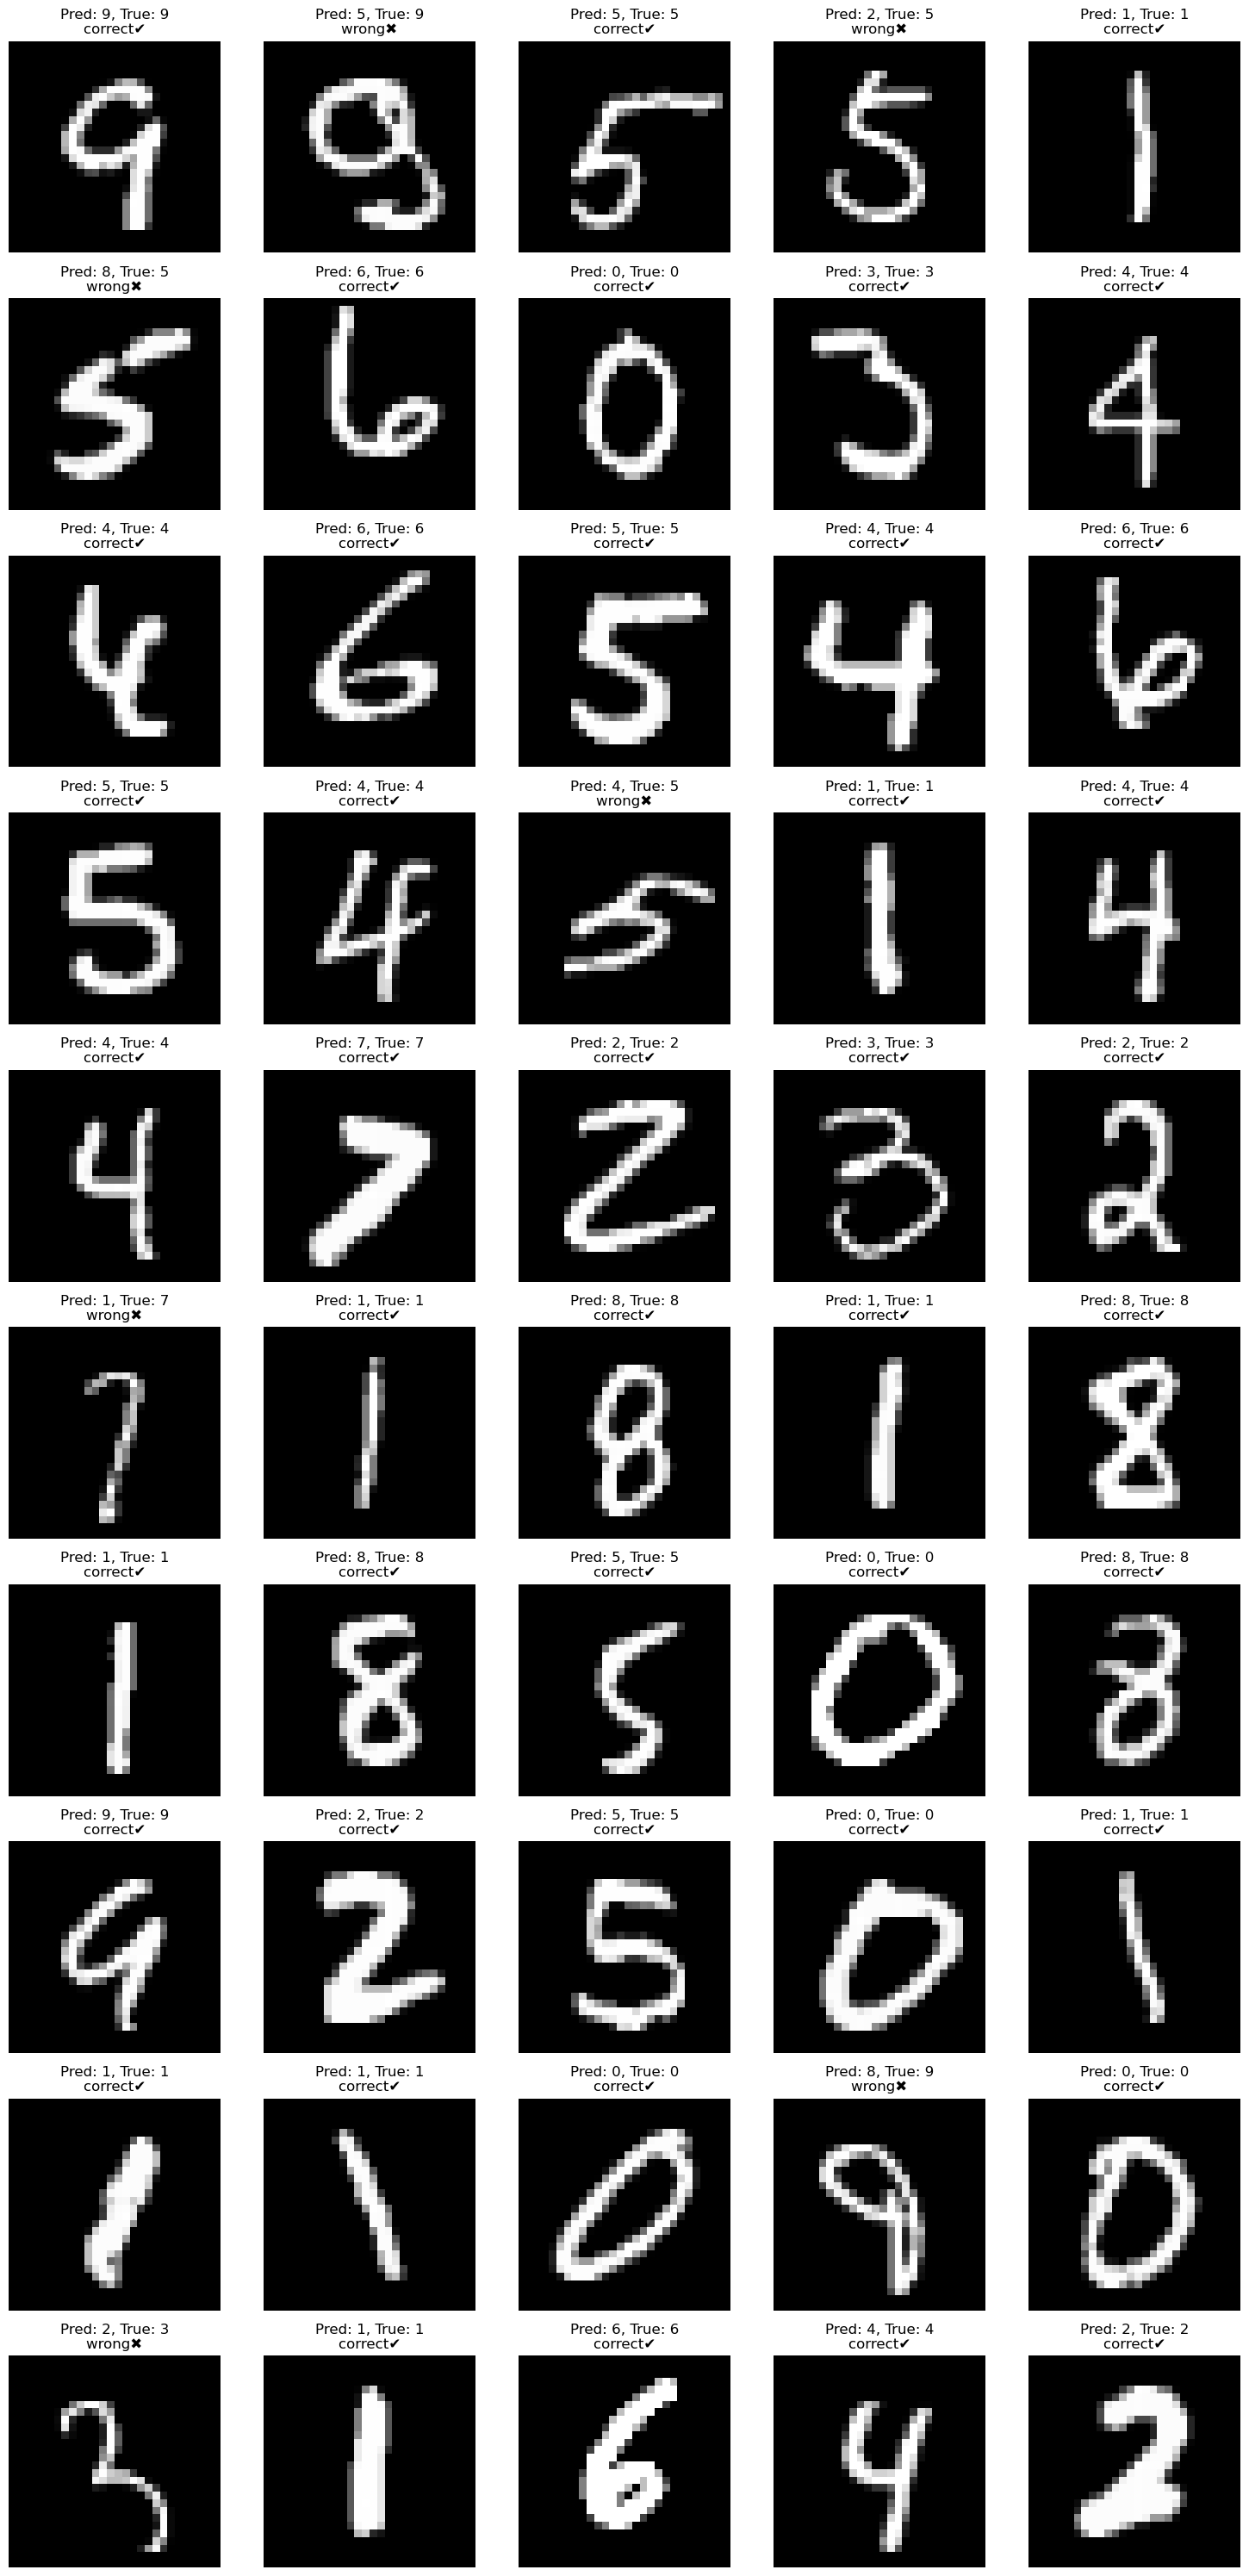

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Specify the range of indices to visualize
start_index = 150
end_index = 200

# Number of rows and columns for the grid
rows = int(np.ceil((end_index - start_index) / 5))  # 5 images per row
cols = 5

# Create a figure
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Iterate through the specified range
for idx, ax in zip(range(start_index, end_index), axes):
    # Predicted and true labels for the current index
    predicted_digit = predictions[idx]
    true_digit = y_test_subset[idx]

    # Reshape the flattened image back to its original shape (28x28)
    image = x_test_subset[idx].reshape(28, 28)

    # Determine correctness
    if predicted_digit == true_digit:
        status = "correct✔️"
    else:
        status = "wrong✖️"
    
    # Plot the image
    ax.imshow(image, cmap='gray')  # Use 'gray' colormap for MNIST
    ax.set_title(f"Pred: {predicted_digit}, True: {true_digit}\n{status}")
    ax.axis("off")  # Hide axes for cleaner visuals

# Turn off unused subplots
for ax in axes[len(range(start_index, end_index)):]:
    ax.axis("off")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

🌿Visual Cross-verification (with indices)

In [7]:
# import matplotlib.pyplot as plt
# import numpy as np

# index_to_visualize = 197

# # predicted digit for this index
# predicted_digit = predictions[index_to_visualize]

# # true digit for this index
# true_digit = y_test_subset[index_to_visualize]

# # Reshape the flattened image back to its original shape (28x28)
# image = x_test_subset[index_to_visualize].reshape(28, 28)

# # Plot the image
# plt.imshow(image, cmap='gray')
# plt.title(f"Predicted: {predicted_digit}, True: {true_digit}")
# plt.show()